In [160]:
import pacepredictor as pp
import importlib
import plotly.express as px
import pandas as pd
import numpy as np
import missingno as msno
import math

display_big_figures = False

importlib.reload(pp)

<module 'pacepredictor' from '/home/adam/projects/Concept2-Pace-Predictor/pacepredictor.py'>

# Predictor

Create a regression model to predict 2000m time.

# Load Data

In [161]:
file_path = "../Concept2-Logbook-Scraper/analysis/"
file_name = "rowing_cleaned_data.csv"

pp_row = pp.Predictor(f"{file_path}{file_name}", random_state=42)

pp_row.df = pp_row.df.drop("profile_id", axis = 1)

pp_row.df

result_1  result_100  result_1000  result_10000  result_100000  \
0           NaN         NaN        255.9           NaN            NaN   
1           NaN         NaN          NaN           NaN            NaN   
2         330.0         NaN          NaN           NaN            NaN   
3           NaN         NaN        203.9        2222.6            NaN   
4           NaN         NaN        236.3        2512.3            NaN   
...         ...         ...          ...           ...            ...   
60688       NaN         NaN          NaN           NaN            NaN   
60689       NaN         NaN        230.4           NaN            NaN   
60690       NaN         NaN        177.0           NaN            NaN   
60691       NaN         NaN          NaN        3202.8            NaN   
60692       NaN         NaN          NaN        2571.6            NaN   

       result_2000  result_21097  result_30  result_4  result_42195  \
0              NaN           NaN        NaN       NaN           NaN   
1              NaN           NaN        NaN       NaN           NaN   
2              NaN        5688.1        NaN       NaN           NaN   
3            416.4           NaN     8215.0       NaN           NaN   
4            474.1           NaN     7289.0    1031.0           NaN   
...            ...           ...        ...       ...           ...   
60688          NaN           NaN        NaN       NaN           NaN   
60689          NaN           NaN        NaN       NaN           NaN   
60690          NaN           NaN        NaN       NaN           NaN   
60691          NaN           NaN        NaN       NaN           NaN   
60692          NaN           NaN        NaN       NaN           NaN   

       result_500  result_5000  result_60  result_6000  \
0             NaN          NaN        NaN          NaN   
1           116.0          NaN        NaN          NaN   
2             NaN          NaN        NaN       1498.0   
3            94.6       1086.8    16144.0       1307.6   
4           107.4       1204.7        NaN       1485.8   
...           ...          ...        ...          ...   
60688         NaN       1304.7        NaN          NaN   
60689         NaN          NaN        NaN          NaN   
60690         NaN          NaN        NaN          NaN   
60691         NaN          NaN        NaN          NaN   
60692         NaN          NaN        NaN          NaN   

      adaptive_rowing_category  age  height  weight weight_class gender  
0                         able   67     NaN    64.9            H      F  
1                         able   62     NaN    72.6            H      F  
2                         able   65   172.7    99.8            H      M  
3                         able   56   188.0    97.1            H      M  
4                         able   67     NaN    86.2            H      M  
...                        ...  ...     ...     ...          ...    ...  
60688                     able   46     NaN     NaN            H      M  
60689                     able   17     NaN     NaN            H      F  
60690                     able   22     NaN     NaN            H      M  
60691                     able   38     NaN     NaN            H      F  
60692                     able   43   185.4    86.2            H      M  

[60693 rows x 20 columns]

# Missing Data

In [162]:
pp.percent_complete(pp_row.df)

result_1                     14.393752
result_100                   10.024220
result_1000                  25.121513
result_10000                 32.926367
result_100000                 0.301517
result_2000                  43.479479
result_21097                 13.706688
result_30                    35.368164
result_4                      7.556061
result_42195                  4.384361
result_500                   21.598866
result_5000                  46.021782
result_60                    11.767420
result_6000                  16.252286
adaptive_rowing_category    100.000000
age                         100.000000
height                       50.971282
weight                       56.077307
weight_class                100.000000
gender                      100.000000
dtype: float64


<AxesSubplot:>

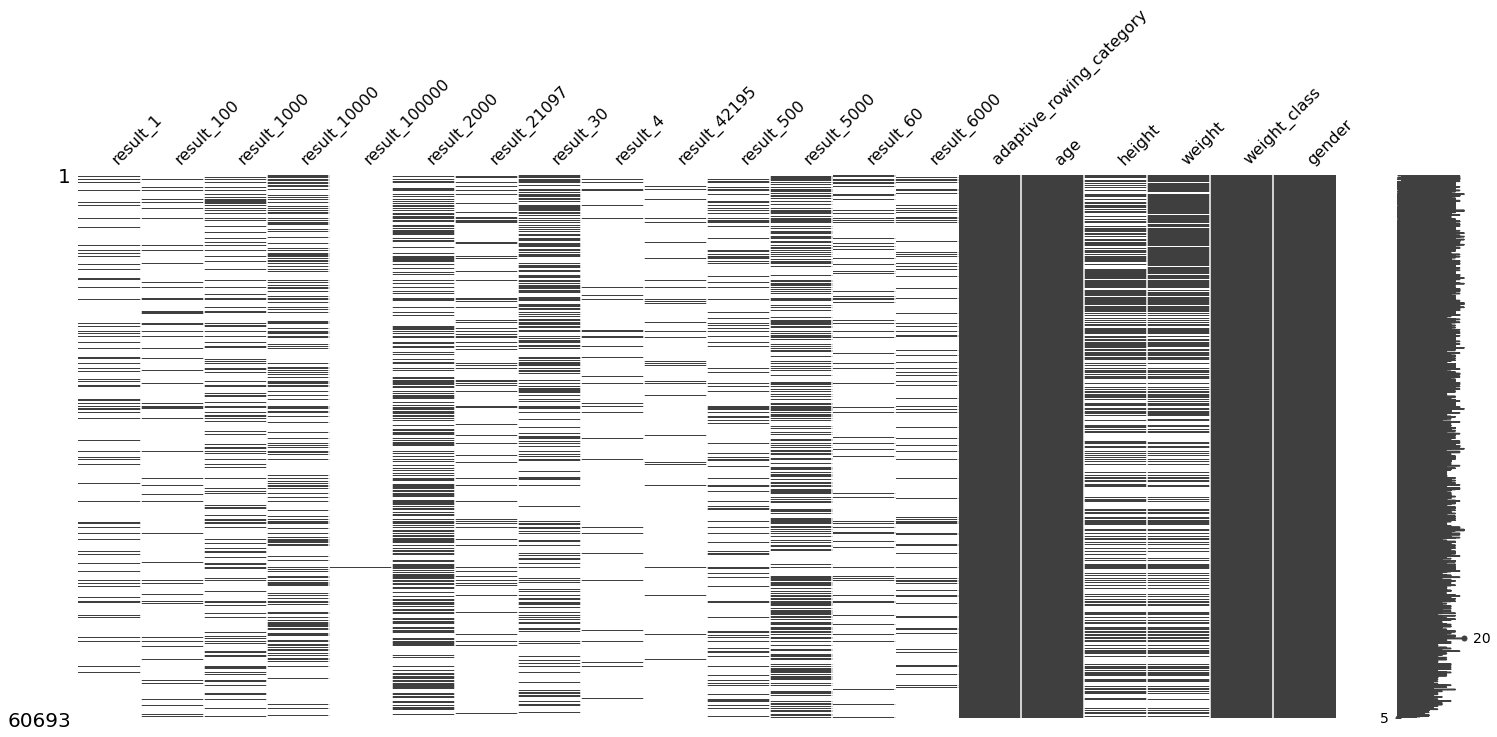

In [163]:
msno.matrix(pp_row.df)

Lots of event results missing, and lots of height and weight missing. Is this data missing randomly or is there a correlation?

<AxesSubplot:>

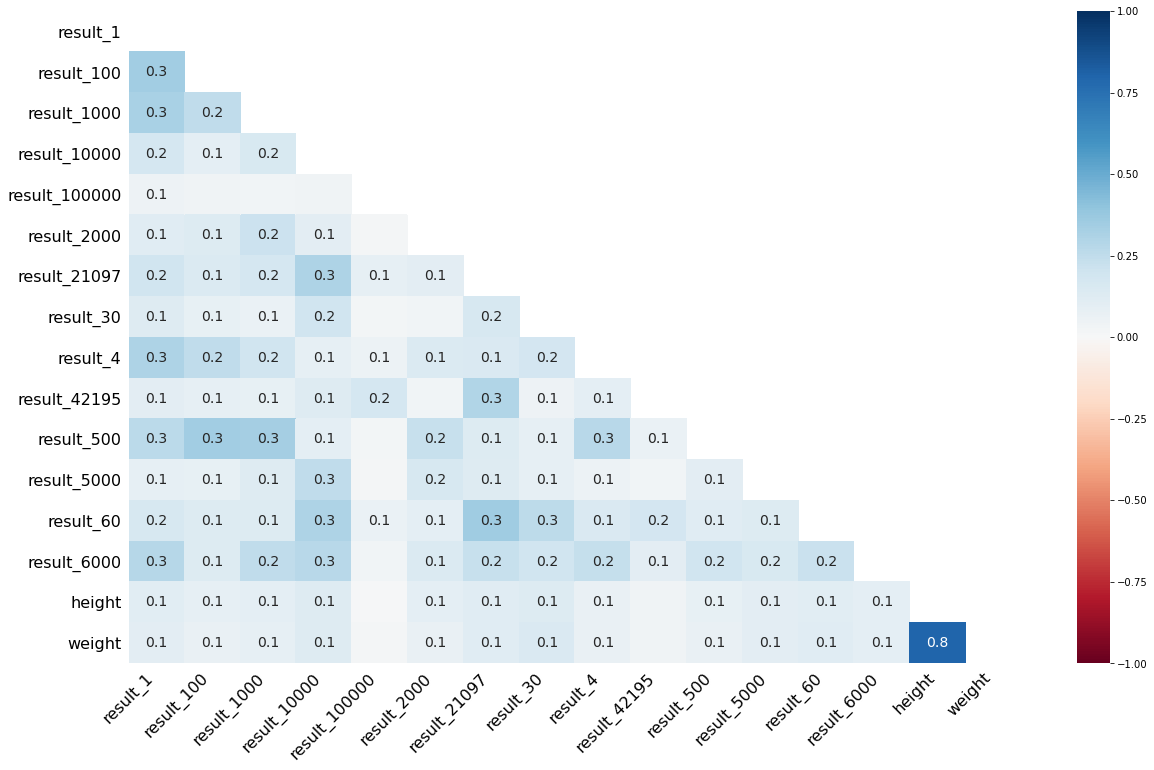

In [164]:
msno.heatmap(pp_row.df)

The missing results are poorly correlated both with other results and with height and weight. Missing results means that the athlete has not recorded a result for this workout. This looks like we can treat this is MCAR (missing completely at random) data. We will drop missing results initially as I don't think imputing will yield good results and there will still be a good amount of data to work with.

Height and weight are highly correlated to eachother in their missingness, but this makes sense given that it is user input from the same web form. We only have about 50% height and weight data, which might be enough to get reasonable imputation, but we will also have plenty of data left if we drop the missing height and weight rows - we will take the later approach initially.

# Visualise Data Distribution

In [165]:
# fig = pp_row.plot_distributions()
# fig.show()

# Further Cleaning

1. Cut off results at maximum at current men's 30-39 world record (usually the fastest time)

In [166]:
distance_row_world_records = {
    100:12.6,
    500:70.5,
    1000:159.5,
    2000:336.6,
    5000:898.3,
    6000:1096.8,
    10000:1865.2,
    21097:4042.7,
    42195:8668.1
}

time_row_world_records = {
    1:430,
    4:1412,
    30:9449,
    60:18602
}


for event, record in distance_row_world_records.items():
    pp_row.df[f"result_{event}"] = pp_row.df[f"result_{event}"].apply(lambda x: x if x > record else np.nan)

for event, record in time_row_world_records.items():
    pp_row.df[f"result_{event}"] = pp_row.df[f"result_{event}"].apply(lambda x: x if x < record else np.nan)

2. Cut off anything slower than 3:00.0 / 500m pace

In [167]:
distance_events_slow = {
    100:0,
    500:0,
    1000:0,
    2000:0,
    5000:0,
    6000:0,
    10000:0,
    21097:0,
    42195:0
}

time_events_slow = {
    1:0,
    4:0,
    30:0,
    60:0
}


#3:00.0 = 180 seconds
slow_cut_off_pace = 180

for event in distance_events_slow:
    distance_events_slow[event] = event/500 * slow_cut_off_pace

for event, slow_pace in distance_events_slow.items():
    pp_row.df[f"result_{event}"] = pp_row.df[f"result_{event}"].apply(lambda x: x if x < slow_pace else np.nan)

for event in time_events_slow:
    time_events_slow[event] = (event*60)/slow_cut_off_pace * 500

for event, slow_pace in time_events_slow.items():
    pp_row.df[f"result_{event}"] = pp_row.df[f"result_{event}"].apply(lambda x: x if x > slow_pace else np.nan)

In [168]:
fig = pp_row.plot_distributions()
if display_big_figures:
    fig.show()

3. Include only able-bodied athletes in this model as we do not have enough para-athletes


In [169]:
indexes_to_drop = pp_row.df[pp_row.df["adaptive_rowing_category"] != "able"].index
pp_row.df.drop(indexes_to_drop, inplace=True)
pp_row.df.drop("adaptive_rowing_category", axis=1, inplace=True)

4. Drop height and weight outliers - most likely errors on form entry

In [170]:
max_height = 209
min_height = 150
max_weight = 150
min_weight = 45

indexes_to_drop = []
indexes_to_drop += pp_row.df[pp_row.df["height"] > max_height].index.to_list()
indexes_to_drop += pp_row.df[pp_row.df["height"] < min_height].index.to_list()
indexes_to_drop += pp_row.df[pp_row.df["weight"] > max_weight].index.to_list()
indexes_to_drop += pp_row.df[pp_row.df["weight"] < min_weight].index.to_list()

pp_row.df.drop(indexes_to_drop, inplace=True)

In [171]:
fig = pp_row.plot_distributions()
# fig.show()

 # Visualisation
 
 Visualise the target against other variables

In [172]:
target = "result_2000"
cont_parameters = pp_row.df.columns.drop([target, "weight_class", "gender"]).to_list()
fig = pp_row.plot_scatters(target, cont_parameters, cols=4)
if display_big_figures:
    fig.show()
# plotly.io.write_image(fig, 'scatters.pdf', format='pdf')

In [173]:
target = "result_2000"
cat_parameters = ["weight_class", "gender"]
fig = pp_row.plot_violins(target, cat_parameters, cols=2, height=1000)
if display_big_figures:
    fig.show()

# Cleaning Complete

Write this data to a file for use later.

In [174]:
pp_row.df.to_csv("cleaned_data.csv")

# Pick Parameters

There are very few profiles that have a complete set of parameters,and for a useful predictor, we don't want an athlete to have to complete every other test. We will keep all the other parameters which are not event results..

Ideally we choose shorter tests that athletes can complete easily, but that we also have a good amount of data for.



In [175]:
pp.percent_complete(pp_row.df)

result_1          14.236355
result_100         9.752963
result_1000       24.414956
result_10000      32.500417
result_100000      0.302120
result_2000       42.487064
result_21097      13.463529
result_30         34.670339
result_4           7.217493
result_42195       4.221332
result_500        21.106660
result_5000       45.182774
result_60         11.625772
result_6000       15.957269
age              100.000000
height            50.652646
weight            55.606743
weight_class     100.000000
gender           100.000000
dtype: float64


We will choose two tests:
- 1000m (result_1000)
- 1 minute (result_1)

Drop rows where we are missing data, and columns we are not using:

In [176]:
target = ["result_2000"]
predictor_results = ["result_1", "result_1000"]
core_columns = ["age", "height", "weight", "weight_class", "gender"]

columns = target + predictor_results + core_columns

pp_row.df = pp_row.df[columns]

#drop nulls
indexes_to_drop = []
for col in columns:
    indexes_to_drop_temp = pp_row.df[pp_row.df[col].isnull()].index.to_list()
    #if len(indexes_to_drop_temp) > 0:
    indexes_to_drop += indexes_to_drop_temp

pp_row.df = pp_row.df.drop(indexes_to_drop)

How big is our dataset now?

In [177]:
len(pp_row.df)

2553

In [178]:
target = "result_2000"
cont_parameters = predictor_results + ["age", "height", "weight"]
fig = pp_row.plot_scatters(target, cont_parameters, cols=3, height=1500)
#fig.show()

In [179]:
fig = px.imshow(pp_row.df[cont_parameters + ["result_2000"]].corr(), title="Correlation heatmap of numerical values")
fig.update_layout(height=800)
fig.show()

All the result parameters are highly correlated, to be expected. We will see how this affects the model but we may need to drop one of the predictor result parameters.

Height and weight also strongly correlated with eachother and results.

# Split Data

Need a train, validation and test set.

70% training data. 15% test and 15% validate

In [180]:
pp_row.split_data()

print("Train: " + str(len(pp_row.df_train)))
print("Val: " + str(len(pp_row.df_test)))
print("Test: " + str(len(pp_row.df_val)))

Train: 1787
Val: 383
Test: 383


# Linear Regression

In [181]:
pp_row.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2553 entries, 10 to 60451
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   result_2000   2553 non-null   float64
 1   result_1      2553 non-null   float64
 2   result_1000   2553 non-null   float64
 3   age           2553 non-null   int64  
 4   height        2553 non-null   float64
 5   weight        2553 non-null   float64
 6   weight_class  2553 non-null   object 
 7   gender        2553 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 179.5+ KB


In [182]:
target = "result_2000"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model("linear", target, parameters)

print(pp_row.models["linear"].model.summary())

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1680.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:42:41   Log-Likelihood:                -7996.0
No. Observations:                1787   AIC:                         1.601e+04
Df Residuals:                    1779   BIC:                         1.605e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           265.0040     21.23

In [183]:
print(f"Mean squared error: {round(pp_row.models['linear'].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models['linear'].mse),1)}s")

Mean squared error: 489.8s
Mean error: 22.1s


In [184]:
fig = pp_row.models["linear"].plot_residuals()
fig.show()

In [185]:
px.histogram(pp_row.models["linear"].df_train["residuals"])

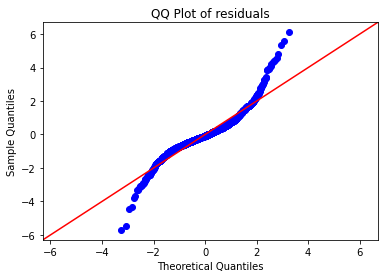

In [186]:
pp_row.models["linear"].plot_QQ()

In [187]:
pp_row.models["linear"].anova()

sum_sq      df            F         PR(>F)
weight_class      63.914379     1.0     0.141123   7.072115e-01
gender          1953.774951     1.0     4.313950   3.794430e-02
result_1       29218.437018     1.0    64.514530   1.726592e-15
result_1000   817109.430520     1.0  1804.183797  8.603977e-273
age            11268.873820     1.0    24.881759   6.689992e-07
height         11387.948402     1.0    25.144676   5.848283e-07
weight          8934.109705     1.0    19.726582   9.484635e-06
Residual      805703.764262  1779.0          NaN            NaN

Weight class is contributing very little to the reduction in sum of squares, and has a high p. It will be highly correlated to weight (by definition) so we are probably best dropping this.

In [188]:
pp_row.df.drop("weight_class", axis=1, inplace=True)


In [189]:
target = "result_2000"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model("linear_2", target, parameters)

print(pp_row.models["linear_2"].model.summary())

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1961.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:42:42   Log-Likelihood:                -7996.1
No. Observations:                1787   AIC:                         1.601e+04
Df Residuals:                    1780   BIC:                         1.604e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     266.7838     20.699     12.889      

In [190]:
print(f"Mean squared error: {round(pp_row.models['linear_2'].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models['linear_2'].mse),1)}s")
fig = pp_row.models["linear_2"].plot_residuals()
fig.show()

Mean squared error: 488.7s
Mean error: 22.1s


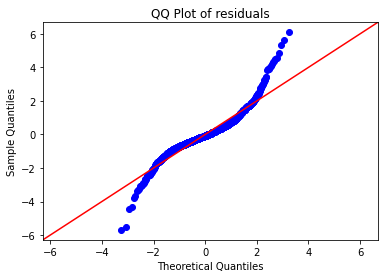

In [191]:
pp_row.models["linear_2"].plot_QQ()

In [192]:
pp_row.models["linear_2"].anova()

sum_sq      df            F         PR(>F)
gender         1898.325421     1.0     4.193540   4.072474e-02
result_1      29215.574971     1.0    64.539352   1.705179e-15
result_1000  817081.751386     1.0  1804.993618  6.376365e-273
age           11213.964402     1.0    24.772471   7.074341e-07
height        12019.625269     1.0    26.552235   2.850033e-07
weight        10991.459563     1.0    24.280942   9.098380e-07
Residual     805767.678641  1780.0          NaN            NaN

Removing weight_class hasn't made a difference to our R^2 or model performance.

All p-values now under our alpha=0.05 threshold and this model is complete, though our residuals do not look normal and suggests a linear model is not a good fit for this data.

Interpretation:

- Being male decreases your 2km time.
- The higher your 1 minute score, the lower your 2km time.
- The lower your 1km time, the lower your 2km time.
- Being younger decreases your 2km time.
    - Rowers tend to peak in late 20s/early 30s, so would actually expect this to be a curve, given the limits of this model this result makes sense
- Being taller decreases your 2km time.
- Being lighter decreases your 2km time.
    - not expected, possibly because very trained lightweights are outperforming unfit heavyweight rowers



TODO: 
- notes on each plot
- try polynomial curve
- just 1 minute test
- compare with paul's law
- boxcox?

# Linear Regression with Polynomial Terms

## 2nd Order

In [198]:
target = "result_2000"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model("2nd_order", target, parameters, order=2)

print(pp_row.models["2nd_order"].model.summary())

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1080.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:42:59   Log-Likelihood:                -7986.5
No. Observations:                1787   AIC:                         1.600e+04
Df Residuals:                    1775   BIC:                         1.606e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       369.5877    160.981      2.296

Mean squared error: 474.99629786231503s
Mean error: 21.8s


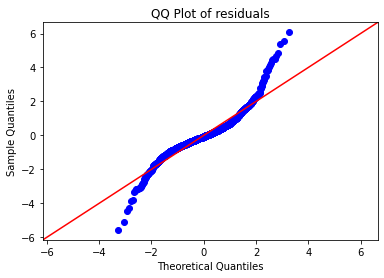

sum_sq      df          F        PR(>F)
gender           1364.838577     1.0   3.038775  8.147040e-02
result_1         5761.130911     1.0  12.826997  3.508558e-04
result_1000     32927.541460     1.0  73.312251  2.359266e-17
age              1044.263274     1.0   2.325023  1.274865e-01
height            406.974178     1.0   0.906117  3.412765e-01
weight            431.340657     1.0   0.960368  3.272277e-01
result_1_2       3187.857709     1.0   7.097676  7.788254e-03
result_1000_2    5166.626281     1.0  11.503349  7.099536e-04
age_2            2800.994946     1.0   6.236337  1.260547e-02
height_2          231.269578     1.0   0.514915  4.731132e-01
weight_2           22.876917     1.0   0.050935  8.214705e-01
Residual       797225.370072  1775.0        NaN           NaN

In [199]:
print(f"Mean squared error: {pp_row.models['2nd_order'].mse}s")
print(f"Mean error: {round(np.sqrt(pp_row.models['2nd_order'].mse),1)}s")
fig = pp_row.models["2nd_order"].plot_residuals()
fig.show()
pp_row.models["2nd_order"].plot_QQ()
pp_row.models["2nd_order"].anova()

Ever so slightly improved R^2. Much worse performance.

Drop highest p:

In [200]:
pp_row.models["2nd_order"].p_max()

Max p: weight_2 p=0.821


In [201]:
target = "result_2000"
model_name = "2nd_order_2"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=2, drop="weight_2")
print(pp_row.models[model_name].model.summary())

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1189.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:43:00   Log-Likelihood:                -7986.6
No. Observations:                1787   AIC:                         1.600e+04
Df Residuals:                    1776   BIC:                         1.606e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       362.5679    157.905      2.296

Mean squared error: 475.7s
Mean error: 21.8s


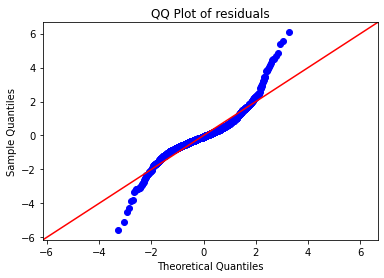

Max p: height_2 p=0.494


In [202]:

print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1321.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:43:00   Log-Likelihood:                -7986.8
No. Observations:                1787   AIC:                         1.599e+04
Df Residuals:                    1777   BIC:                         1.605e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       257.8086     37.930      6.797

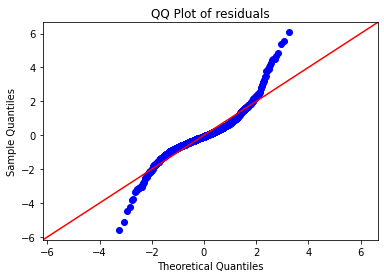

Max p: age p=0.126


In [203]:
model_name = "2nd_order_2"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=2, drop=["weight_2", "height_2"])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1485.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:43:01   Log-Likelihood:                -7988.0
No. Observations:                1787   AIC:                         1.599e+04
Df Residuals:                    1778   BIC:                         1.604e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       247.8062     37.375      6.630

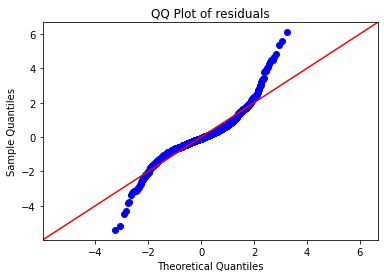

Max p: gender[T.M] p=0.047


In [204]:
model_name = "2nd_order_3"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=2, drop=["weight_2", "height_2", "age"])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

## 3rd Order

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     754.7
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:43:01   Log-Likelihood:                -7971.7
No. Observations:                1787   AIC:                         1.598e+04
Df Residuals:                    1770   BIC:                         1.607e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4337.9823   1794.243     -2.418

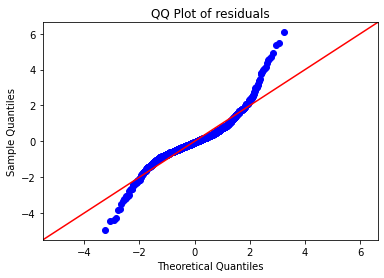

Max p: result_1000 p=0.665


In [205]:
model_name = "3rd_order"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=3, drop=[])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

In [206]:
pp_row.models["3rd_order"].df_val

result_2000  result_1  result_1000  age  height  weight weight_class  \
0          540.5     299.0        221.2   67   180.3    88.5            H   
1          452.2     334.0        204.5   51   182.9    95.3            H   
2          415.4     342.0        205.5   48   193.0   122.5            H   
3          406.7     338.0        189.8   27   185.4    84.8            H   
4          419.6     330.0        201.9   53   188.0    82.1            H   
..           ...       ...          ...  ...     ...     ...          ...   
378        425.0     325.0        192.0   41   172.7    86.2            H   
379        407.3     337.0        183.1   45   190.5    99.8            H   
380        487.1     267.0        248.7   39   180.3    84.8            H   
381        517.1     313.0        232.4   48   182.9    85.3            H   
382        432.7     272.0        225.3   45   193.0   112.9            H   

    gender  result_1_2  result_1000_2  age_2  height_2  weight_2  result_1_3  \
0        M     89401.0       48929.44   4489  32508.09   7832.25  26730899.0   
1        M    111556.0       41820.25   2601  33452.41   9082.09  37259704.0   
2        M    116964.0       42230.25   2304  37249.00  15006.25  40001688.0   
3        M    114244.0       36024.04    729  34373.16   7191.04  38614472.0   
4        M    108900.0       40763.61   2809  35344.00   6740.41  35937000.0   
..     ...         ...            ...    ...       ...       ...         ...   
378      M    105625.0       36864.00   1681  29825.29   7430.44  34328125.0   
379      M    113569.0       33525.61   2025  36290.25   9960.04  38272753.0   
380      M     71289.0       61851.69   1521  32508.09   7191.04  19034163.0   
381      M     97969.0       54009.76   2304  33452.41   7276.09  30664297.0   
382      M     73984.0       50760.09   2025  37249.00  12746.41  20123648.0   

     result_1000_3   age_3     height_3     weight_3  result_2000_pred  \
0     1.082319e+07  300763  5861208.627   693154.125        469.554528   
1     8.552241e+06  132651  6118445.789   865523.177        431.845728   
2     8.678316e+06  110592  7189057.000  1838265.625        433.859470   
3     6.837363e+06   19683  6372783.864   609800.192        401.607257   
4     8.230173e+06  148877  6644672.000   553387.661        422.601560   
..             ...     ...          ...          ...               ...   
378   7.077888e+06   68921  5150827.583   640503.928        417.747133   
379   6.138539e+06   91125  6913292.625   994011.992        395.907663   
380   1.538252e+07   59319  5861208.627   609800.192        514.249374   
381   1.255187e+07  110592  6118445.789   620650.477        476.071246   
382   1.143625e+07   91125  7189057.000  1439069.689        480.069990   

     squared_error  
0      5033.260047  
1       414.296389  
2       340.752036  
3        25.936035  
4         9.009363  
..             ...  
378      52.604085  
379     129.785335  
380     737.088516  
381    1683.358683  
382    2243.915926  

[383 rows x 20 columns]

In [207]:
pp_row.models["2nd_order"].df_val

result_2000  result_1  result_1000  age  height  weight weight_class  \
0          540.5     299.0        221.2   67   180.3    88.5            H   
1          452.2     334.0        204.5   51   182.9    95.3            H   
2          415.4     342.0        205.5   48   193.0   122.5            H   
3          406.7     338.0        189.8   27   185.4    84.8            H   
4          419.6     330.0        201.9   53   188.0    82.1            H   
..           ...       ...          ...  ...     ...     ...          ...   
378        425.0     325.0        192.0   41   172.7    86.2            H   
379        407.3     337.0        183.1   45   190.5    99.8            H   
380        487.1     267.0        248.7   39   180.3    84.8            H   
381        517.1     313.0        232.4   48   182.9    85.3            H   
382        432.7     272.0        225.3   45   193.0   112.9            H   

    gender  result_1_2  result_1000_2  age_2  height_2  weight_2  \
0        M     89401.0       48929.44   4489  32508.09   7832.25   
1        M    111556.0       41820.25   2601  33452.41   9082.09   
2        M    116964.0       42230.25   2304  37249.00  15006.25   
3        M    114244.0       36024.04    729  34373.16   7191.04   
4        M    108900.0       40763.61   2809  35344.00   6740.41   
..     ...         ...            ...    ...       ...       ...   
378      M    105625.0       36864.00   1681  29825.29   7430.44   
379      M    113569.0       33525.61   2025  36290.25   9960.04   
380      M     71289.0       61851.69   1521  32508.09   7191.04   
381      M     97969.0       54009.76   2304  33452.41   7276.09   
382      M     73984.0       50760.09   2025  37249.00  12746.41   

     result_2000_pred  squared_error  
0          470.730630    4867.765038  
1          433.247640     359.191968  
2          434.807832     376.663955  
3          402.977979      13.853439  
4          425.218717      31.569979  
..                ...            ...  
378        415.097166      98.066114  
379        394.264017     169.936843  
380        511.886221     614.356769  
381        477.420539    1574.459638  
382        477.340677    1992.790039  

[383 rows x 15 columns]

In [208]:
pp_row.models["linear"].df_val

result_2000  result_1  result_1000  age  height  weight weight_class  \
0          540.5     299.0        221.2   67   180.3    88.5            H   
1          452.2     334.0        204.5   51   182.9    95.3            H   
2          415.4     342.0        205.5   48   193.0   122.5            H   
3          406.7     338.0        189.8   27   185.4    84.8            H   
4          419.6     330.0        201.9   53   188.0    82.1            H   
..           ...       ...          ...  ...     ...     ...          ...   
378        425.0     325.0        192.0   41   172.7    86.2            H   
379        407.3     337.0        183.1   45   190.5    99.8            H   
380        487.1     267.0        248.7   39   180.3    84.8            H   
381        517.1     313.0        232.4   48   182.9    85.3            H   
382        432.7     272.0        225.3   45   193.0   112.9            H   

    gender  result_2000_pred  squared_error  
0        M        470.259748    4933.692978  
1        M        434.551041     311.485767  
2        M        434.976962     383.257454  
3        M        403.600117       9.609273  
4        M        427.123718      56.606333  
..     ...               ...            ...  
378      M        418.650562      40.315360  
379      M        399.023923      68.493454  
380      M        510.943191     568.497760  
381      M        477.369986    1578.473977  
382      M        477.521813    2008.994921  

[383 rows x 10 columns]

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     4378.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:43:02   Log-Likelihood:                -8702.3
No. Observations:                1787   AIC:                         1.741e+04
Df Residuals:                    1785   BIC:                         1.742e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    887.7898      6.307    140.764      0.0

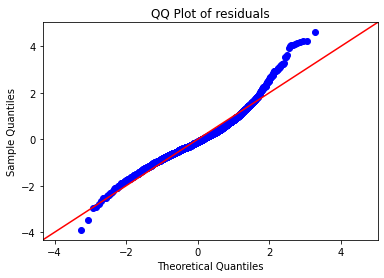

Max p: Intercept p=0.0


In [209]:
model_name = "single_parameter_test"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=1, drop=["result_1000", "age", "height",	"weight", "gender"])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

In [210]:
import plotly.graph_objects as go

pp_row.models[model_name].df_train = pp_row.models[model_name].df_train.sort_values(by="result_1")

pp_row.models[model_name].df_train["predict"] = pp_row.models[model_name].model.predict(pp_row.models[model_name].df_train)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=pp_row.df_train["result_1"], y=pp_row.df_train["result_2000"], name="scatter_name", mode="markers"))

fig.add_trace(go.Scatter(
     x=pp_row.models[model_name].df_train["result_1"], y=pp_row.models[model_name].df_train["predict"], name="line_name"))

fig.update_layout(title="title", xaxis_title="x_title",
    yaxis_title="y_title")

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     2270.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:43:02   Log-Likelihood:                -8678.8
No. Observations:                1787   AIC:                         1.736e+04
Df Residuals:                    1784   BIC:                         1.738e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1123.4169     34.708     32.368      0.0

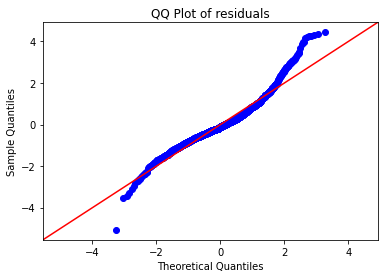

Max p: result_1_2 p=0.0


In [211]:
model_name = "single_parameter_test_2nd"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=2, drop=["result_1000", "age", "height",	"weight", "gender", "result_1000_2", "age_2", "height_2",	"weight_2"])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

In [212]:

pp_row.models[model_name].df_train = pp_row.models[model_name].df_train.sort_values(by="result_1")

pp_row.models[model_name].df_train["predict"] = pp_row.models[model_name].model.predict(pp_row.models[model_name].df_train)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=pp_row.df_train["result_1"], y=pp_row.df_train["result_2000"], name="scatter_name", mode="markers"))

fig.add_trace(go.Scatter(
     x=pp_row.models[model_name].df_train["result_1"], y=pp_row.models[model_name].df_train["predict"], name="line_name"))

fig.update_layout(title="title", xaxis_title="x_title",
    yaxis_title="y_title")